In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import nltk
from nltk.util import ngrams
import string

# Ensure nltk ngrams are available
nltk.download('punkt', quiet=True)

# ===== 1. Load and Clean Data =====
with open("corpus.txt", "r") as f:
    words = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

print(f"Total words in corpus: {len(words)}")
print(f"Unique words: {len(set(words))}")

# ===== 2. WORD LENGTH DISTRIBUTION =====
word_lengths = [len(w) for w in words]
plt.figure(figsize=(8,4))
sns.histplot(word_lengths, bins=20, kde=False, color='skyblue')
plt.title("Word Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

# ===== 3. LETTER FREQUENCY ANALYSIS =====
letters = [ch for w in words for ch in w]
letter_counts = Counter(letters)
letter_freq_df = pd.DataFrame(letter_counts.items(), columns=['Letter', 'Count']).sort_values('Count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=letter_freq_df, x='Letter', y='Count', palette='viridis')
plt.title("Letter Frequency Distribution (A–Z)")
plt.show()

# ===== 4. POSITION-SPECIFIC LETTER FREQUENCY =====
max_len = max(word_lengths)
pos_freq = defaultdict(Counter)

for w in words:
    for idx, ch in enumerate(w):
        pos_freq[idx][ch] += 1

# Convert to DataFrame (heatmap form)
pos_df = pd.DataFrame(pos_freq).fillna(0).astype(int)
plt.figure(figsize=(12,6))
sns.heatmap(pos_df, cmap="YlGnBu")
plt.title("Position-Specific Letter Frequency Heatmap")
plt.xlabel("Position in Word (0-indexed)")
plt.ylabel("Letter")
plt.show()

# ===== 5. N-GRAM PATTERN ANALYSIS =====
# Example: Bigrams and Trigrams across all words
bigrams = Counter()
trigrams = Counter()

for w in words:
    bigrams.update(ngrams(w, 2))
    trigrams.update(ngrams(w, 3))

# Top 20 most common bigrams & trigrams
print("\nTop 20 Bigrams:")
print(bigrams.most_common(20))
print("\nTop 20 Trigrams:")
print(trigrams.most_common(20))

# Visualization of bigrams
bigram_df = pd.DataFrame(bigrams.most_common(20), columns=['Bigram','Count'])
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ''.join(x))
plt.figure(figsize=(10,5))
sns.barplot(data=bigram_df, x='Bigram', y='Count', palette='mako')
plt.title("Top 20 Most Common Bigrams")
plt.show()

# Visualization of trigrams
trigram_df = pd.DataFrame(trigrams.most_common(20), columns=['Trigram','Count'])
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ''.join(x))
plt.figure(figsize=(10,5))
sns.barplot(data=trigram_df, x='Trigram', y='Count', palette='mako')
plt.title("Top 20 Most Common Trigrams")
plt.show()

# ===== 6. VOWEL DISTRIBUTION ANALYSIS =====
vowels = set('aeiou')
vowel_counts = {v:0 for v in vowels}
for w in words:
    for v in vowels:
        vowel_counts[v] += w.count(v)

vowel_df = pd.DataFrame(vowel_counts.items(), columns=['Vowel', 'Count']).sort_values('Count', ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(data=vowel_df, x='Vowel', y='Count', palette='crest')
plt.title("Vowel Frequency Distribution")
plt.show()

# ===== 7. DIFFICULT WORD ANALYSIS =====
# Define "difficult" as words containing mostly rare letters (like q, x, z, j)
rare_letters = set(['q','x','z','j'])
difficulty_score = []

for w in words:
    rare_count = sum(ch in rare_letters for ch in w)
    score = rare_count / len(w)
    difficulty_score.append((w, score))

diff_df = pd.DataFrame(difficulty_score, columns=['Word','DifficultyScore'])
top_difficult = diff_df.sort_values('DifficultyScore', ascending=False).head(20)
print("\nTop 20 Difficult Words (rare-letter proportion):")
print(top_difficult)

plt.figure(figsize=(10,5))
sns.barplot(data=top_difficult, x='Word', y='DifficultyScore', palette='rocket')
plt.xticks(rotation=90)
plt.title("Top 20 Difficult Words by Rare-Letter Proportion")
plt.show()


In [ ]:
# ==== HANGMAN HMM TRAINING - SIMPLIFIED FOR SPEED (WITH STATE RANGE SEARCH) ====

from hmmlearn import hmm
import numpy as np
import pickle, time, math
from collections import Counter, defaultdict


# ====================== CONFIGURATION (SIMPLIFIED) ======================
RANGES = {
    "HMM_1": (3, 5),
    "HMM_2": (6, 7),
    "HMM_3": (8, 9),
    "HMM_4": (10, 12),
    "HMM_5": (13, 99)
}

# ⚡ OPTIMIZATION 1: Fixed iteration count (early stopping)
N_ITER = 12  # Was 200, now stops early
TOL = 0.01   # Loose tolerance

# ⚡ OPTIMIZATION 2: Fewer random restarts
SEEDS = [42, 301, 123]  # 3 seeds instead of 10

# ⚡ OPTIMIZATION 3: STATE RANGE SEARCH (you specify the ranges)
STATE_RANGES = {
    "HMM_1": (4, 5),      # Try 4 and 5 states, pick best
    "HMM_2": (5, 7),      # Try 5, 6, 7 states, pick best
    "HMM_3": (5, 7),      # Try 5, 6, 7 states, pick best
    "HMM_4": (4, 6),      # Try 4, 5, 6 states, pick best
    "HMM_5": (4, 5)       # Try 4 and 5 states, pick best
}

ALPHAS = {"HMM_1": 0.10, "HMM_2": 0.10, "HMM_3": 0.15, "HMM_4": 0.20, "HMM_5": 0.20}

VERBOSE = False


# ====================== LOAD & PREPROCESS ======================
with open("corpus.txt", "r") as f:
    words = [w.strip().lower() for w in f if w.strip().isalpha()]

alphabet = list("abcdefghijklmnopqrstuvwxyz")
V = len(alphabet)
char_to_idx = {ch: i for i, ch in enumerate(alphabet)}


def word_to_seq(word: str) -> np.ndarray:
    """Convert word -> one-hot encoded matrix of shape (len(word), 26)."""
    seq = np.zeros((len(word), V), dtype=int)
    for i, ch in enumerate(word):
        seq[i, char_to_idx[ch]] = 1
    return seq


# Group words by length range
range_groups = {key: [] for key in RANGES}
for w in words:
    l = len(w)
    for model_id, (low, high) in RANGES.items():
        if low <= l <= high:
            range_groups[model_id].append(w)
            break


# ====================== POSITIONAL LETTER STATS ======================
positional_freq = defaultdict(lambda: Counter())
for w in words:
    for i, ch in enumerate(w):
        positional_freq[i][ch] += 1


# ====================== HELPERS ======================
def dirichlet_jitter(vec, seed, strength=1e-2):
    """Perturb a probability vector slightly but keep it on simplex."""
    rng = np.random.default_rng(seed)
    alpha = np.clip(vec * (1.0 / strength), 1e-6, None)
    return rng.dirichlet(alpha)


def row_normalize(mat):
    s = mat.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return mat / s


def bic_value(avg_ll, n_states, N_obs, V):
    """Compute Bayesian Information Criterion to select best state count."""
    K = (n_states - 1) + n_states * (n_states - 1) + n_states * (V - 1)
    return -2.0 * avg_ll + K * math.log(max(N_obs, 1))


# ====================== TRAINING LOOP ======================
trained_models = {}
log_likelihoods = {}


for model_id, word_list in range_groups.items():
    if not word_list:
        print(f"⚠️ {model_id} has no words, skipping.")
        continue

    print(f"\n🔹 Training {model_id} on {len(word_list)} words "
          f"({RANGES[model_id][0]}–{RANGES[model_id][1]} chars)")

    # Concatenate all words
    X = np.concatenate([word_to_seq(w) for w in word_list])
    lengths = [len(w) for w in word_list]
    N_obs = len(X)
    alpha = ALPHAS[model_id]

    # Evaluation sample
    sample_size = min(200, len(word_list))
    rng = np.random.default_rng(12345)
    eval_words = rng.choice(word_list, sample_size, replace=False)

    best_model, best_bic, best_loglike = None, float('inf'), -float('inf')

    # ==== STATE RANGE SEARCH (YOUR RANGES) ====
    min_states, max_states = STATE_RANGES[model_id]
    for n_states in range(min_states, max_states + 1):

        best_restart_model, best_restart_ll = None, -float('inf')

        # ==== 3 RANDOM RESTARTS ====
        for seed in SEEDS:
            model = hmm.MultinomialHMM(
                n_components=n_states,
                n_iter=N_ITER,
                tol=TOL,
                random_state=seed,
                init_params="",
                params="ste",
                verbose=VERBOSE
            )

            # ---- Informed Initialization ----
            transmat = np.zeros((n_states, n_states), dtype=float)
            for i in range(n_states):
                if i < n_states - 1:
                    transmat[i, i] = 0.9
                    transmat[i, i + 1] = 0.1
                else:
                    transmat[i, i] = 1.0
            model.transmat_ = row_normalize(transmat)

            startprob = np.ones(n_states) / n_states
            startprob = dirichlet_jitter(startprob, seed + 17, strength=5e-3)
            model.startprob_ = startprob / startprob.sum()

            emission = np.zeros((n_states, V), dtype=float)
            for i in range(n_states):
                pos_stats = positional_freq.get(i, Counter())
                total = sum(pos_stats.values()) + alpha * V
                for j, ch in enumerate(alphabet):
                    emission[i, j] = (pos_stats[ch] + alpha) / total
                emission[i] = dirichlet_jitter(emission[i], seed + 1000 + i, strength=5e-3)
            model.emissionprob_ = row_normalize(emission)

            # ---- Train model ----
            start_time = time.time()
            model.fit(X, lengths)
            duration = time.time() - start_time

            # ---- Evaluate LL on sample ----
            ll_vals = []
            for w in eval_words:
                try:
                    seq = word_to_seq(w)
                    ll_vals.append(model.score(seq))
                except Exception:
                    continue
            avg_ll = float(np.mean(ll_vals)) if ll_vals else -np.inf

            if avg_ll > best_restart_ll:
                best_restart_ll = avg_ll
                best_restart_model = model

            if VERBOSE:
                print(f"      seed={seed:4d}, LL={avg_ll:.4f}, time={duration:.2f}s")

        # ---- Compute BIC for this state count ----
        bic = bic_value(best_restart_ll, n_states, N_obs, V)
        print(f"   → n_states={n_states:2d}, AvgLL={best_restart_ll:.4f}, BIC={bic:.2f}")

        # Track best state count by BIC
        if bic < best_bic:
            best_bic, best_model, best_loglike = bic, best_restart_model, best_restart_ll

    trained_models[model_id] = best_model
    log_likelihoods[model_id] = best_loglike
    print(f"✅ Best {model_id}: {best_model.n_components} states, "
          f"Avg LL={best_loglike:.4f}, BIC={best_bic:.2f}")


# ====================== SAVE MODELS ======================
for model_id, model in trained_models.items():
    with open(f"{model_id}.pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"💾 Saved {model_id}")


# ====================== SUMMARY ======================
print("\n📊 ==== TRAINING SUMMARY ====")
for mid, model in trained_models.items():
    low, high = RANGES[mid]
    print(f"{mid:6s} | Range: {low:2d}-{high:2d} | Words: {len(range_groups[mid]):5d} | "
          f"States: {model.n_components:2d} | Avg LL: {log_likelihoods[mid]:.4f}")
print("\n⚡ Optimized HMMs trained with state range search!")


In [ ]:


import pickle
import numpy as np
import torch
import torch.nn as nn
from string import ascii_lowercase as alphabet
from hmmlearn import hmm
import time


HMM_RANGES = {
    "HMM_1": (3, 5),
    "HMM_2": (6, 7),
    "HMM_3": (8, 9),
    "HMM_4": (10, 12),
    "HMM_5": (13, 99)
}

trained_hmms = {}
for model_id in HMM_RANGES.keys():
    with open(f"{model_id}.pkl", "rb") as f:
        trained_hmms[model_id] = pickle.load(f)
print("✅ Loaded all HMM models.")

# ==========================================================
# 2️⃣ DQN MODEL (41 → 256 → 128 → 26)
# ==========================================================

class DQN(nn.Module):
    def __init__(self, input_dim=41, output_dim=26):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn_agent = DQN().to(device)

checkpoint = torch.load("best_dqn_hangman_1.pt", map_location=device)
if "policy_state" in checkpoint:
    state_dict = checkpoint["policy_state"]
else:
    state_dict = checkpoint

if list(state_dict.keys())[0].startswith("layers."):
    state_dict = {k.replace("layers.", "net."): v for k, v in state_dict.items()}
    print("🔧 Fixed key mapping from 'layers' → 'net'.")

dqn_agent.load_state_dict(state_dict)
dqn_agent.eval()
print("✅ DQN loaded successfully.")


class HangmanEnv:
    def __init__(self, word, max_lives=6):
        self.word = word
        self.pattern = "_" * len(word)
        self.lives = max_lives
        self.guessed = set()

    def step(self, guess):
        if guess in self.guessed:
            return self.pattern, -0.5, False
        self.guessed.add(guess)
        if guess in self.word:
            self.pattern = "".join([c if c in self.guessed else "_" for c in self.word])
            reward = 1 if "_" in self.pattern else 10
            done = "_" not in self.pattern
            return self.pattern, reward, done
        else:
            self.lives -= 1
            done = self.lives == 0
            return self.pattern, -1, done

char_to_idx = {ch: i for i, ch in enumerate(alphabet)}

def select_hmm(word):
    for model_id, (low, high) in HMM_RANGES.items():
        if low <= len(word) <= high:
            return trained_hmms[model_id]
    return trained_hmms["HMM_5"]

def get_hmm_letter_probs(hmm_model, pattern, guessed):
    probs = np.zeros(len(alphabet))
    for i, ch in enumerate(alphabet):
        if ch in guessed:
            probs[i] = 0
        else:
            hypothetical = pattern.replace("_", ch)
            seq = np.zeros((len(hypothetical), len(alphabet)))
            for j, c in enumerate(hypothetical):
                seq[j, char_to_idx[c]] = 1
            try:
                probs[i] = np.exp(hmm_model.score(seq))
            except:
                probs[i] = 0
    if probs.sum() == 0:
        probs += 1
    probs /= probs.sum()
    return probs

def state_vector(pattern, guessed, hmm_probs):
    pattern_vec = np.zeros(26)
    for ch in pattern:
        if ch != "_":
            pattern_vec[char_to_idx[ch]] = 1
    guessed_vec = np.array([1 if ch in guessed else 0 for ch in alphabet])
    combined = np.concatenate([pattern_vec, guessed_vec])
    reduced = np.concatenate([combined[:20], hmm_probs[:21]])  # match 41 inputs
    return torch.tensor(reduced, dtype=torch.float32).unsqueeze(0)



def play_demo(word, alpha=0.7):
    env = HangmanEnv(word)
    hmm_model = select_hmm(word)

    print(f"\n🎯 Target Word: {word}")
    print(f"🔠 Word Length: {len(word)} | Lives: {env.lives}\n")

    while True:
        hmm_probs = get_hmm_letter_probs(hmm_model, env.pattern, env.guessed)
        s = state_vector(env.pattern, env.guessed, hmm_probs).to(device)

        with torch.no_grad():
            q_values = dqn_agent(s).cpu().numpy().flatten()

        for ch in env.guessed:
            q_values[char_to_idx[ch]] = -1e9

        q_soft = np.exp(q_values - np.max(q_values))
        q_soft /= q_soft.sum()
        combined = alpha * q_soft + (1 - alpha) * hmm_probs

        guess = alphabet[np.argmax(combined)]
        prev_lives = env.lives
        next_pattern, _, done = env.step(guess)

        correct = guess in env.word
        print(f"👉 Guess: '{guess}' | {'✅ Correct' if correct else '❌ Wrong'} | Pattern: {next_pattern} | Lives: {env.lives}")
        time.sleep(0.7)

        if done:
            if "_" not in next_pattern:
                print("\n🏆 Agent WON! The word was:", word)
            else:
                print("\n💀 Agent LOST! The word was:", word)
            break



demo_words = ["ample", "never", "amuse", "octet", "emit","alphabet", "xylophone"]
for w in demo_words:
    play_demo(w)


✅ Loaded all HMM models.
🔧 Fixed key mapping from 'layers' → 'net'.
✅ DQN loaded successfully.

🎯 Target Word: ample
🔠 Word Length: 5 | Lives: 6

👉 Guess: 'a' | ✅ Correct | Pattern: a____ | Lives: 6
👉 Guess: 'e' | ✅ Correct | Pattern: a___e | Lives: 6
👉 Guess: 'p' | ✅ Correct | Pattern: a_p_e | Lives: 6
👉 Guess: 'l' | ✅ Correct | Pattern: a_ple | Lives: 6
👉 Guess: 'u' | ❌ Wrong | Pattern: a_ple | Lives: 5
👉 Guess: 'i' | ❌ Wrong | Pattern: a_ple | Lives: 4
👉 Guess: 'm' | ✅ Correct | Pattern: ample | Lives: 4

🏆 Agent WON! The word was: ample

🎯 Target Word: never
🔠 Word Length: 5 | Lives: 6

👉 Guess: 'a' | ❌ Wrong | Pattern: _____ | Lives: 5
👉 Guess: 'e' | ✅ Correct | Pattern: _e_e_ | Lives: 5
👉 Guess: 'o' | ❌ Wrong | Pattern: _e_e_ | Lives: 4
👉 Guess: 'l' | ❌ Wrong | Pattern: _e_e_ | Lives: 3
👉 Guess: 'i' | ❌ Wrong | Pattern: _e_e_ | Lives: 2
👉 Guess: 't' | ❌ Wrong | Pattern: _e_e_ | Lives: 1
👉 Guess: 'm' | ❌ Wrong | Pattern: _e_e_ | Lives: 0

💀 Agent LOST! The word was: never

🎯 Targe

✅ Loaded 5 HMM models successfully.
🔧 Fixed key mapping from 'layers' → 'net'.
✅ Loaded DQN weights successfully.
🧪 Evaluating on 2000 test words...

📊 ======== FINAL EVALUATION RESULTS ========
✅ Success Rate: 14.20% (284/2000)
✉️ Letter Accuracy: 49.90%
❌ Avg. Wrong Guesses: 5.71
🔁 Avg. Repeated Guesses: 0.00
🏆 Final Score: -56856.00


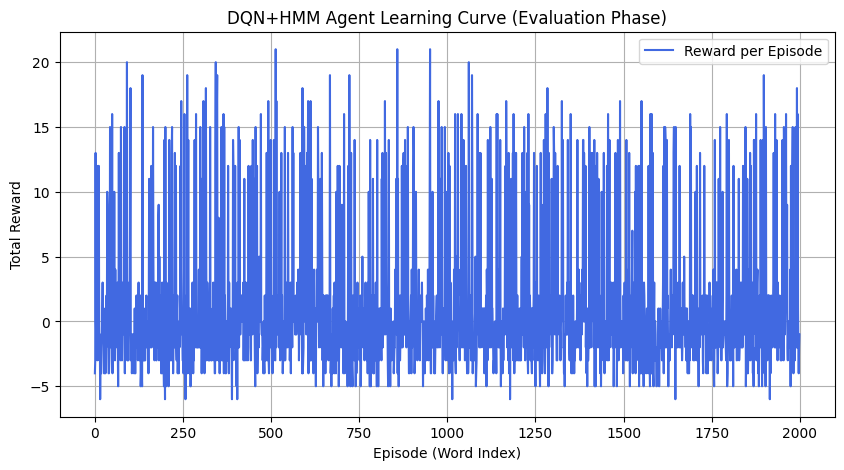

In [ ]:


import pickle
import numpy as np
import torch
import torch.nn as nn
from string import ascii_lowercase as alphabet
from hmmlearn import hmm
import matplotlib.pyplot as plt


HMM_RANGES = {
    "HMM_1": (3, 5),
    "HMM_2": (6, 7),
    "HMM_3": (8, 9),
    "HMM_4": (10, 12),
    "HMM_5": (13, 99)
}

trained_hmms = {}
for model_id in HMM_RANGES.keys():
    with open(f"{model_id}.pkl", "rb") as f:
        trained_hmms[model_id] = pickle.load(f)
print(f"✅ Loaded {len(trained_hmms)} HMM models successfully.")



class DQN(nn.Module):
    def __init__(self, input_dim=41, output_dim=26):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn_agent = DQN(input_dim=41, output_dim=26).to(device)

checkpoint = torch.load("best_dqn_hangman_1.pt", map_location=device)
if "policy_state" in checkpoint:
    state_dict = checkpoint["policy_state"]
else:
    state_dict = checkpoint

if list(state_dict.keys())[0].startswith("layers."):
    new_state_dict = {k.replace("layers.", "net."): v for k, v in state_dict.items()}
    state_dict = new_state_dict
    print("🔧 Fixed key mapping from 'layers' → 'net'.")

dqn_agent.load_state_dict(state_dict)
print("✅ Loaded DQN weights successfully.")
dqn_agent.eval()



class HangmanEnv:
    def __init__(self, word, max_lives=6):
        self.word = word
        self.pattern = "_" * len(word)
        self.lives = max_lives
        self.guessed = set()

    def step(self, guess):
        if guess in self.guessed:
            return self.pattern, -0.5, False
        self.guessed.add(guess)
        if guess in self.word:
            self.pattern = "".join([c if c in self.guessed else "_" for c in self.word])
            reward = 1 if "_" in self.pattern else 10
            done = "_" not in self.pattern
            return self.pattern, reward, done
        else:
            self.lives -= 1
            done = self.lives == 0
            return self.pattern, -1, done



char_to_idx = {ch: i for i, ch in enumerate(alphabet)}

def select_hmm(word):
    for model_id, (low, high) in HMM_RANGES.items():
        if low <= len(word) <= high:
            return trained_hmms[model_id]
    return trained_hmms["HMM_5"]

def get_hmm_letter_probs(hmm_model, pattern, guessed):
    probs = np.zeros(len(alphabet))
    for i, ch in enumerate(alphabet):
        if ch in guessed:
            probs[i] = 0
        else:
            hypothetical = pattern.replace("_", ch)
            seq = np.zeros((len(hypothetical), len(alphabet)))
            for j, c in enumerate(hypothetical):
                seq[j, char_to_idx[c]] = 1
            try:
                probs[i] = np.exp(hmm_model.score(seq))
            except:
                probs[i] = 0
    if probs.sum() == 0:
        probs += 1
    probs /= probs.sum()
    return probs

def state_vector(pattern, guessed, hmm_probs):
    """Reduce to 41 features for compatibility"""
    pattern_vec = np.zeros(26)
    for ch in pattern:
        if ch != "_":
            pattern_vec[char_to_idx[ch]] = 1
    guessed_vec = np.array([1 if ch in guessed else 0 for ch in alphabet])
    combined = np.concatenate([pattern_vec, guessed_vec])  # 52 features
    reduced = np.concatenate([combined[:20], hmm_probs[:21]])  # simple projection
    return torch.tensor(reduced, dtype=torch.float32).unsqueeze(0)


with open("test.txt") as f:
    test_words = [w.strip().lower() for w in f if w.strip().isalpha()]

print(f"🧪 Evaluating on {len(test_words)} test words...")

ALPHA = 0.7
rewards_per_episode = []
wrong_list, repeat_list = [], []

wins, total_guesses, correct_guesses = 0, 0, 0
wrong_guesses, repeated_guesses = 0, 0

for word in test_words:
    env = HangmanEnv(word)
    hmm_model = select_hmm(word)
    total_reward = 0
    wrong_game, repeat_game = 0, 0

    while True:
        hmm_probs = get_hmm_letter_probs(hmm_model, env.pattern, env.guessed)
        s = state_vector(env.pattern, env.guessed, hmm_probs).to(device)

        with torch.no_grad():
            q_values = dqn_agent(s).cpu().numpy().flatten()

        for ch in env.guessed:
            q_values[char_to_idx[ch]] = -1e9

        q_soft = np.exp(q_values - np.max(q_values))
        q_soft /= q_soft.sum()
        combined = ALPHA * q_soft + (1 - ALPHA) * hmm_probs

        guess = alphabet[np.argmax(combined)]
        total_guesses += 1
        if guess in env.guessed:
            repeated_guesses += 1
            repeat_game += 1

        prev_lives = env.lives
        next_state, reward, done = env.step(guess)
        total_reward += reward

        if env.lives < prev_lives:
            wrong_guesses += 1
            wrong_game += 1
        elif guess in env.word:
            correct_guesses += 1

        if done:
            if "_" not in next_state:
                wins += 1
            break

    rewards_per_episode.append(total_reward)
    wrong_list.append(wrong_game)
    repeat_list.append(repeat_game)



success_rate = wins / len(test_words)
letter_acc = (correct_guesses / total_guesses) * 100
avg_wrong = np.mean(wrong_list)
avg_repeat = np.mean(repeat_list)
score = (success_rate * 2000) - (wrong_guesses * 5) - (repeated_guesses * 2)

print("\n📊 ======== FINAL EVALUATION RESULTS ========")
print(f"✅ Success Rate: {success_rate * 100:.2f}% ({wins}/{len(test_words)})")
print(f"✉️ Letter Accuracy: {letter_acc:.2f}%")
print(f"❌ Avg. Wrong Guesses: {avg_wrong:.2f}")
print(f"🔁 Avg. Repeated Guesses: {avg_repeat:.2f}")
print(f"🏆 Final Score: {score:.2f}")
print("=============================================")



plt.figure(figsize=(10,5))
plt.plot(rewards_per_episode, label="Reward per Episode", color='royalblue')
plt.xlabel("Episode (Word Index)")
plt.ylabel("Total Reward")
plt.title("DQN+HMM Agent Learning Curve (Evaluation Phase)")
plt.legend()
plt.grid(True)
plt.show()
